In [1]:
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import utils
from IrisDataset import IrisDataset
from model import Model

%load_ext autoreload
%autoreload 2

In [2]:
data = utils.getNpyFromCsv('data/Iris.csv', utils.labelsToIdx)
X, y = data[:,:-1], data[:, -1]

In [3]:
dataset = IrisDataset(X, y)
print("Number of total samples: {}".format(len(dataset)))

Number of total samples: 150


In [4]:
test_size = int(0.2 * len(dataset))
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print("Training samples: {}".format(len(train_dataset)))
print("Validation samples: {}".format(len(val_dataset)))
print("Testing samples: {}".format(len(test_dataset)))

Training samples: 90
Validation samples: 30
Testing samples: 30


In [5]:
train_loader = DataLoader(train_dataset, batch_size = utils.params['batch-size'], shuffle = True, num_workers = 8)
val_loader = DataLoader(val_dataset, batch_size = utils.params['batch-size'], shuffle = True, num_workers = 8)
test_loader = DataLoader(test_dataset, batch_size = utils.params['batch-size'], shuffle = True, num_workers = 8)

## Training set up

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = Model()
net.to(device)
net = net.float()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),
                      lr = utils.params['lr'],
                      weight_decay = utils.params['weight-decay'])

scheduler = None

In [7]:
summary(net, input_size = (1, 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]              50
              ReLU-2                [-1, 1, 10]               0
            Linear-3                [-1, 1, 20]             220
              ReLU-4                [-1, 1, 20]               0
            Linear-5                [-1, 1, 10]             210
              ReLU-6                [-1, 1, 10]               0
            Linear-7                 [-1, 1, 3]              33
           Softmax-8                 [-1, 1, 3]               0
Total params: 513
Trainable params: 513
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [8]:
writer = SummaryWriter()

train_stats = {
    'running-train-loss': 0.0,
    'running-val-loss': 0.0,
    'running-train-acc': 0.0,
    'running-val-acc': 0.0,
    'train-loss-epochs': [],
    'train-acc-epochs': [],
    'val-loss-epochs': [],
    'val-acc-epochs': []
}

## Training!

In [9]:
print("Training across {} batches, validating on {} batches".format(len(train_loader), len(val_loader)))

for epoch in range(utils.params['epochs']):
    train_stats['running-train-loss'] = 0.0
    train_stats['running-train-acc'] = 0.0
    
    all_samples = 0
    correct = 0
    
    net.train()
    for i, batch in enumerate(train_loader):
        inputs, labels = batch['x'], batch['y']
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        net_outputs = net(inputs.float())
        loss = loss_func(net_outputs, labels)
        loss.backward()
        optimizer.step()
        
        correct += utils.getAccuracy(net_outputs, labels)
        all_samples += net_outputs.shape[0]
        
        train_stats['running-train-loss'] += loss.item()
    train_stats['running-train-acc'] = correct*1.0/all_samples
    
    # Validation
    train_stats['running-val-loss'] = 0.0
    net.eval()
    all_samples = 0
    correct = 0
    for _, batch in enumerate(val_loader):
        inputs, labels = batch['x'], batch['y']
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        net_outputs = net(inputs.float())
        
        correct += utils.getAccuracy(net_outputs, labels)
        val_loss = loss_func(net_outputs, labels)
        train_stats['running-val-loss'] += val_loss.item()
        all_samples += net_outputs.shape[0]
        
        train_stats['running-val-loss'] += loss.item()
    train_stats['running-val-acc'] = correct*1.0/all_samples
    
    # Decreasing the learning rate
    if scheduler:
        scheduler.step(train_stats['running-val-acc'])
    
    # logging statistics
    print("Epoch {0} --> Training loss: {1:.3f} Training acc: {2:.3f} Validation loss: {3:.3f} Validation acc:{4:.3f}"
          .format(epoch + 1,
                  train_stats['running-train-loss'],
                  train_stats['running-train-acc'],
                  train_stats['running-val-loss'],
                  train_stats['running-val-acc']))
    writer.add_scalar("Loss/train", train_stats['running-train-loss'], epoch + 1)
    writer.add_scalar("Loss/validation", train_stats['running-val-loss'], epoch + 1)
    writer.add_scalar("Accuracy/train", train_stats['running-train-acc'], epoch + 1)
    writer.add_scalar("Accuracy/validation", train_stats['running-val-acc'], epoch + 1)
    
    train_stats['train-loss-epochs'].append(train_stats['running-train-loss'])
    train_stats['val-loss-epochs'].append(train_stats['running-val-loss'])
    train_stats['train-acc-epochs'].append(train_stats['running-train-acc'])
    train_stats['val-acc-epochs'].append(train_stats['running-val-acc'])

writer.close()

Training across 6 batches, validating on 2 batches
Epoch 1 --> Training loss: 6.590 Training acc: 0.256 Validation loss: 4.369 Validation acc:0.400
Epoch 2 --> Training loss: 6.513 Training acc: 0.378 Validation loss: 4.311 Validation acc:0.233
Epoch 3 --> Training loss: 6.400 Training acc: 0.378 Validation loss: 4.196 Validation acc:0.233
Epoch 4 --> Training loss: 6.204 Training acc: 0.411 Validation loss: 4.009 Validation acc:0.600
Epoch 5 --> Training loss: 5.918 Training acc: 0.611 Validation loss: 3.751 Validation acc:0.833
Epoch 6 --> Training loss: 5.444 Training acc: 0.856 Validation loss: 3.408 Validation acc:0.933
Epoch 7 --> Training loss: 4.956 Training acc: 0.833 Validation loss: 3.420 Validation acc:0.933
Epoch 8 --> Training loss: 4.486 Training acc: 0.944 Validation loss: 2.978 Validation acc:1.000
Epoch 9 --> Training loss: 4.275 Training acc: 0.922 Validation loss: 2.891 Validation acc:0.867
Epoch 10 --> Training loss: 4.231 Training acc: 0.867 Validation loss: 2.587

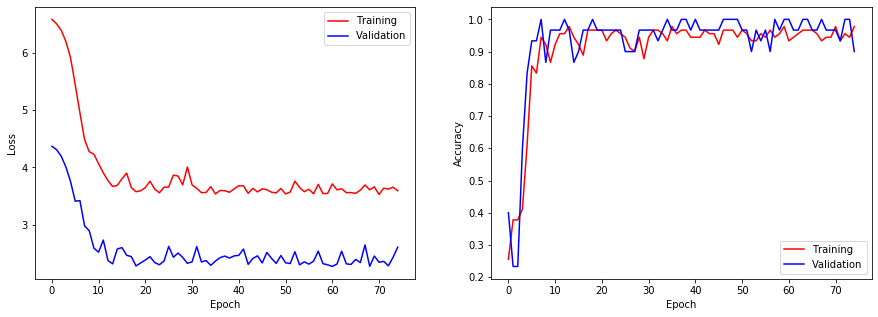

In [10]:
fig, (loss_graph, acc_graph) = plt.subplots(1, 2, figsize=(15, 5))
loss_graph.plot(train_stats['train-loss-epochs'], color = 'red', label = 'Training')
loss_graph.plot(train_stats['val-loss-epochs'], color = 'blue', label = 'Validation')
loss_graph.set_xlabel("Epoch")
loss_graph.set_ylabel("Loss")
loss_graph.legend()

acc_graph.plot(train_stats['train-acc-epochs'], color = 'red', label = 'Training')
acc_graph.plot(train_stats['val-acc-epochs'], color = 'blue', label = 'Validation')
acc_graph.set_xlabel("Epoch")
acc_graph.set_ylabel("Accuracy")
acc_graph.legend()

plt.show()

## Saving the model

In [11]:
torch.save(net.state_dict, 'iris-classifier.pth')
print("Model saved.")

Model saved.


## Finally, testing on the test set

In [12]:
test_loss, test_correct = 0, 0
for _, batch in enumerate(test_loader):
    inputs, labels = batch['x'], batch['y']
        
    inputs = torch.DoubleTensor(inputs)
    labels = torch.LongTensor(labels)

    inputs = inputs.to(device)
    labels = labels.to(device)

    net_outputs = net(inputs.float())

    test_correct += utils.getAccuracy(net_outputs, labels)
    test_loss = loss_func(net_outputs, labels).item()

print("Testing loss: {0:.4f}".format(test_loss))
print("Samples correctly predicted: {}/{}".format(test_correct, len(test_dataset)))
print("Testing accuracy: {0:.4f}".format(test_correct * 1.0 / len(test_dataset)))

Testing loss: 0.5790
Samples correctly predicted: 27/30
Testing accuracy: 0.9000


In [13]:
import torchvision

example = torch.rand(1, 4)
traced_script_module = torch.jit.trace(net, example)
traced_script_module.save("android-iris-classifer.pt")